In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
import scipy.stats as stats

In [2]:
base_dir = '..\\data\\'

pickles = ['df_sj.pkl', 'df_iq.pkl',
           'sj_bayes.pkl', 'iq_bayes.pkl']

#read in prepocessed dataframes
with open(base_dir+pickles[0],'rb') as f:
    sj = pickle.load(f)

sj_Y = sj[['total_cases']]

with open(base_dir+pickles[1],'rb') as f:
    iq = pickle.load(f)
    
iq_Y = iq[['total_cases']]
    
with open(base_dir+pickles[2],'rb') as f:
    sj_X = pickle.load(f)
    
with open(base_dir+pickles[3],'rb') as f:
    iq_X = pickle.load(f)

In [3]:
# Removing the temporal features
iq_X_nodates = iq_X.drop(['weekofyear','year','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], axis= 1)
sj_X_nodates = sj_X.drop(['weekofyear','year','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], axis= 1)

In [4]:
iq_Xtrain, iq_Xtest, iq_Ytrain, iq_Ytest = train_test_split(iq_X_nodates, iq_Y, shuffle= False, test_size= 0.25)
sj_Xtrain, sj_Xtest, sj_Ytrain, sj_Ytest = train_test_split(sj_X_nodates, sj_Y, shuffle= False, test_size= 0.25)
print("IQ train size {}, IQ test size {}".format(iq_Xtrain.shape[0], iq_Xtest.shape[0]))
print("SJ train size {}, SJ test size {}".format(sj_Xtrain.shape[0], sj_Xtest.shape[0]))

IQ train size 390, IQ test size 130
SJ train size 702, SJ test size 234


In [5]:
# set random seed
np.random.seed(1)

# features to get the rolling window sum for, as standing water is important to the lifecycle of mosquitoes. 
#    This wouldn't be represented well by a rolling mean if there was a week of heavy rain, and dry weeks after
rolling_sum_features=[
    'precipitation_amt_mm',
    'reanalysis_sat_precip_amt_mm',
    'station_precip_mm']

# Features to get a rolling window average for. Rolling sum doesn't make sense for things like temperature, 
#    where the sum would be much higher than the city has ever seen.
rolling_avg_features=[
    'ndvi_ne',
    'ndvi_nw',
    'ndvi_se',
    'ndvi_sw',
    'reanalysis_min_air_temp_c',
    'reanalysis_max_air_temp_c',
    'reanalysis_dew_point_temp_c',
    'reanalysis_avg_temp_c',
    'reanalysis_air_temp_c',
    'station_min_temp_c',
    'station_max_temp_c',
    'station_diur_temp_rng_c',
    'station_avg_temp_c',
    'reanalysis_tdtr_k',
    'reanalysis_specific_humidity_g_per_kg',
    'reanalysis_relative_humidity_percent']

def roll_features(X):
    """Rolling window of features
        params:
            X: dataframe with columns in rolling_sum_features and rolling_avg_features"""
    df = X.copy()
    for f in rolling_sum_features:
        df['rolled_sum_'+ f] = df[f].rolling(3).sum()
        
    for f in rolling_avg_features:
        df['rolled_avg_'+ f] = df[f].rolling(3).mean()
        
    return df


def roll_cases(X, how='mean', window=3):
    """Rolling calculation for case numbers
        params:
            X: DataFrame of shape[:, 1] or flat numpy array
            how: method to use; {'mean', 'sum'}, default='mean'
            window: size of rolling window to use in calculation of 'how', default=3"""
    isdf = False
    if isinstance(X, pd.DataFrame):
        isdf = True
        x = X.to_numpy().ravel()
        idx = X.index
    else:
        x = X
        
    shape = x.shape[:-1] + (x.shape[-1] - window + 1, window)
    strides = x.strides + (x.strides[-1],)

    if how == 'mean':
         rolled = np.mean(np.lib.stride_tricks.as_strided(x, shape= shape, strides= strides), 1)
    elif how == 'sum':
        rolled =  np.sum(np.lib.stride_tricks.as_strided(x, shape= shape, strides= strides), 1)
        
    rolled = np.append([0,0], rolled)
    df = pd.DataFrame(rolled, columns= ['total_cases'])
    if isdf:
        df.index = idx
        
    return df


def rmsle(ytrue, ypred):
    y = ytrue.to_numpy() if isinstance(ytrue, pd.DataFrame) else ytrue
    return np.mean(np.sqrt((np.power(np.log1p(ypred) - np.log1p(y), 2))/(len(y))))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)


def smape(ytrue, ypred):
    """Symmetric Mean absolute percentage error"""
    true = ytrue.to_numpy().ravel() if isinstance(ytrue, pd.DataFrame) else ytrue
    
    smape_score = 1/len(true) * np.sum((np.abs(ypred - true)) / (np.abs(true) + np.abs(ypred)))
    return smape_score


def getscores(ytrue, ypred, log=False):
    """Print RMSE, MAE, SMAPE, R^2 scores"""
    scores = {}
    scores['MAE'] = mean_absolute_error(ytrue, ypred)
    scores['SMAPE'] = smape(ytrue, ypred)
    if log is False:
        scores['RMSE'] = mean_squared_error(ytrue, ypred, squared= False) 
    else:
        scores['RMSLE'] = rmsle(ytrue, ypred)
        
    return scores

In [6]:
# Training
# Get 3 week rolling values
iq_XtrainRolled = roll_features(iq_Xtrain).fillna(method = 'bfill')
sj_XtrainRolled = roll_features(sj_Xtrain).fillna(method = 'bfill')

# Testing
iq_XtestRolled = roll_features(iq_Xtest).fillna(method = 'bfill')
sj_XtestRolled = roll_features(sj_Xtest).fillna(method = 'bfill')

In [7]:
tscv = TimeSeriesSplit(10)

# Gradient Boosting Regressor

### Iquitos

In [8]:
# # Some different sample weights
# iq_ytrain_sqrt = np.sqrt(iq_Ytrain)
# iq_ytrain_sqrt_weight = iq_ytrain_sqrt +0.1
sj_ytrain_sqrt = np.sqrt(sj_Ytrain)
sj_ytrain_sqrt_weight = sj_ytrain_sqrt +0.1

In [ ]:
# iq_gbr_grid = {'learning_rate': np.arange(0.01, 0.1, 0.01),
#                   'n_estimators': range(100, 1001, 100)}

# iq_gbr = GradientBoostingRegressor(random_state= 1)
# gs = GridSearchCV(iq_gbr, iq_gbr_grid, cv= tscv, scoring= 'neg_root_mean_squared_error', n_jobs= -1)
# gs.fit(iq_XtrainRolled, iq_Ytrain.values.ravel())
# gs.best_params_

In [37]:
iq_gbr_grid = {'learning_rate': 0.01, 'n_estimators': 100}

iq_gbr = GradientBoostingRegressor(random_state= 1, **iq_gbr_grid)
iq_gbr.fit(iq_XtrainRolled, iq_Ytrain.values.ravel())
iq_gbr_pred = iq_gbr.predict(iq_XtestRolled)

{'MAE': 8.143143444628821,
 'SMAPE': 0.44412204310148756,
 'RMSE': 13.023045341051033}

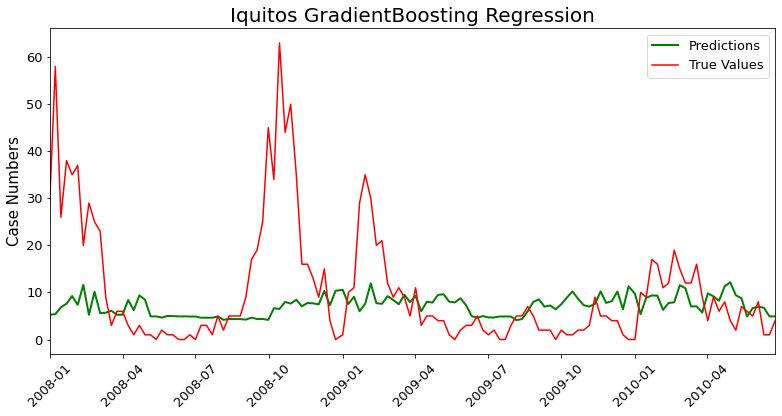

In [38]:
plt.figure(figsize= (13,6))
plt.plot(iq_Ytest.index, iq_gbr_pred, color= 'g', lw= 2, label= "Predictions")
plt.plot(iq_Ytest, color= 'r', label= "True Values")
plt.title("Iquitos GradientBoosting Regression", size= 20)
plt.ylabel("Case Numbers", size= 15)
plt.yticks(size= 13)
plt.xticks(rotation= 45, size= 13)
plt.xlim(iq_Ytest.index[0], iq_Ytest.index[-1])
plt.legend(fontsize= 13)
display(getscores(iq_Ytest, iq_gbr_pred))

### San Juan

In [15]:
# sj_gbr_grid = {'learning_rate': np.arange(0.01, 0.1, 0.01),
#                'n_estimators': range(100, 1001, 100)}

# sj_gbr = GradientBoostingRegressor(random_state= 1)
# gs = GridSearchCV(sj_gbr, sj_gbr_grid, cv= tscv, scoring= 'neg_root_mean_squared_error', n_jobs= -1).fit(sj_XtrainRolled, sj_Ytrain.values.ravel())
# gs.best_params_

In [39]:
sj_gbr_grid = {'learning_rate': 0.01, 'n_estimators': 100}

sj_gbr = GradientBoostingRegressor(random_state = 1, **sj_gbr_grid)
sj_gbr.fit(sj_XtrainRolled, sj_Ytrain.values.ravel())
sj_gbr_pred = sj_gbr.predict(sj_XtestRolled)

{'MAE': 25.48891012728875,
 'SMAPE': 0.48078072855944387,
 'RMSE': 30.484686816828752}

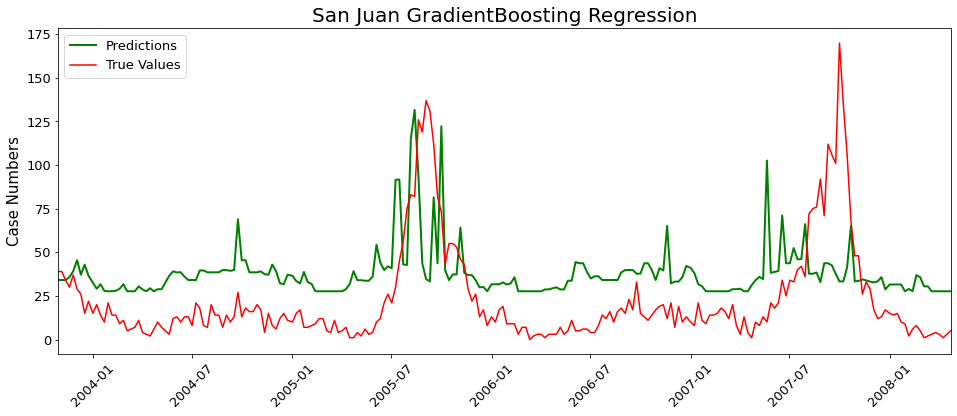

In [41]:
plt.figure(figsize= (13,6))
plt.plot(sj_Ytest.index, sj_gbr_pred, color= 'g', lw= 2, label= "Predictions")
plt.plot(sj_Ytest, color= 'r', label= "True Values")
plt.title("San Juan GradientBoosting Regression", size= 20)
plt.ylabel("Case Numbers", size= 15)
plt.yticks(size= 13)
plt.xticks(rotation= 45, size= 13)
plt.xlim(sj_Ytest.index[0], sj_Ytest.index[-1])
plt.legend(fontsize= 13)
display(getscores(sj_Ytest, sj_gbr_pred))

In [11]:
# i = RFECV(iq_gbr, cv= tscv, scoring= rmsle_scorer, n_jobs= -1).fit(iq_XtrainRolled, iq_Ytrain.values.ravel())
# iq_RFEfeats = iq_XtrainRolled.columns[i.get_support()]
# iq_RFEfeats

In [12]:
iq_RFEfeats = ['reanalysis_specific_humidity_g_per_kg', 
                   'reanalysis_tdtr_k',
                   'reanalysis_max_air_temp_c',
                   'reanalysis_min_air_temp_c',
                   'rolled_sum_precipitation_amt_mm',
                   'rolled_sum_reanalysis_sat_precip_amt_mm', 
                   'rolled_avg_ndvi_se',
                   'rolled_avg_ndvi_sw',
                   'rolled_avg_reanalysis_min_air_temp_c',
                   'rolled_avg_reanalysis_dew_point_temp_c',
                   'rolled_avg_station_min_temp_c',
                   'rolled_avg_station_max_temp_c',
                   'rolled_avg_station_diur_temp_rng_c',
                   'rolled_avg_station_avg_temp_c',
                   'rolled_avg_reanalysis_tdtr_k']

In [13]:
# iq_gbr_feat_grid = {'learning_rate': np.arange(0.01, 0.1, 0.01),
#                   'n_estimators': np.arange(100, 1001, 100)}

# iq_gbr_feat = GradientBoostingRegressor(random_state= 1)
# gs = GridSearchCV(iq_gbr_feat, iq_gbr_feat_grid, cv= tscv, scoring= rmsle_scorer, n_jobs= -1)
# gs.fit(iq_XtrainRolled[iq_RFEfeats], iq_Ytrain.values.ravel())
# gs.best_params_

In [ ]:
iq_gbr_feat_grid = {'learning_rate': 0.01, 'n_estimators': 100}
iq_gbr_feat = GradientBoostingRegressor(random_state= 1, **iq_gbr_feat_grid)
iq_gbr_feat.fit(iq_XtrainRolled[iq_RFEfeats], iq_Ytrain.values.ravel())
iq_gbr_feat_pred = iq_gbr_feat.predict(iq_XtestRolled[iq_RFEfeats])

{'MAE': 8.15371597733526,
 'SMAPE': 0.4455324306141187,
 'RMSE': 13.054631711386053}

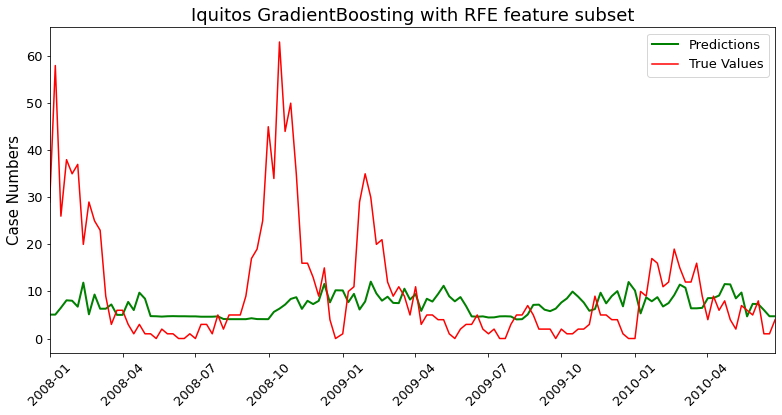

In [47]:
plt.figure(figsize= (13,6))
plt.plot(iq_Ytest.index, iq_gbr_feat_pred, color= 'g', lw= 2, label= "Predictions")
plt.plot(iq_Ytest, color= 'r', label= "True Values")
plt.title("Iquitos GradientBoosting with RFE feature subset", size= 18)
plt.ylabel("Case Numbers", size= 15)
plt.yticks(size= 13)
plt.xticks(rotation= 45, size= 13)
plt.xlim(iq_Ytest.index[0], iq_Ytest.index[-1])
plt.legend(fontsize= 13)
display(getscores(iq_Ytest, iq_gbr_feat_pred))

In [15]:
# s = RFECV(sj_gbr, cv= tscv, scoring= rmsle_scorer, n_jobs= -1).fit(sj_XtrainRolled, sj_Ytrain.values.ravel())
# sj_RFEfeats = sj_XtrainRolled.columns[s.get_support()]
# sj_RFEfeats

In [16]:
sj_RFEfeats= ['ndvi_nw', 
                  'reanalysis_precip_amt_kg_per_m2',
                  'reanalysis_relative_humidity_percent',
                  'station_max_temp_c',
                  'reanalysis_dew_point_temp_c',
                  'rolled_avg_ndvi_ne',
                  'rolled_avg_ndvi_se',
                  'rolled_avg_reanalysis_dew_point_temp_c',
                  'rolled_avg_station_min_temp_c',
                  'rolled_avg_station_max_temp_c',
                  'rolled_avg_station_diur_temp_rng_c',
                  'rolled_avg_reanalysis_tdtr_k',
                  'rolled_avg_reanalysis_specific_humidity_g_per_kg',
                  'rolled_avg_reanalysis_relative_humidity_percent']

In [17]:
# sj_rfe_grid = {'learning_rate': np.arange(0.01, 0.1, 0.01),
#               'n_estimators': range(100, 1001, 100)}

# sj_gbr_rfe = GradientBoostingRegressor(random_state= 1)
# gs = GridSearchCV(sj_gbr_rfe, sj_rfe_grid, cv= tscv, scoring= 'neg_root_mean_squared_error', n_jobs= -1)
# gs.fit(sj_XtrainRolled[sj_RFEfeats], sj_Ytrain.values.ravel())
# gs.best_params_

In [ ]:
sj_rfe_grid = {'learning_rate': 0.01, 'n_estimators': 100}
sj_gbr_rfe = GradientBoostingRegressor(random_state= 1, **sj_rfe_grid)
sj_gbr_rfe.fit(sj_XtrainRolled[sj_RFEfeats], sj_Ytrain.values.ravel())
sj_gbr_rfe_pred = sj_gbr_rfe.predict(sj_XtestRolled[sj_RFEfeats])

{'MAE': 25.41783161604617,
 'SMAPE': 0.4791594503410759,
 'RMSE': 30.649102911213088}

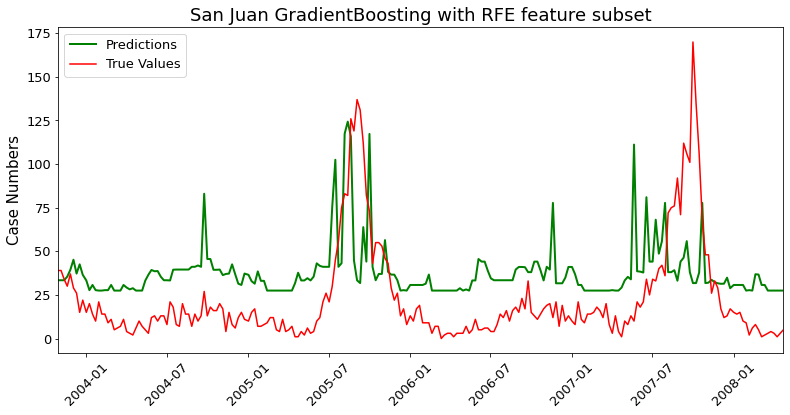

In [48]:
plt.figure(figsize= (13,6))
plt.plot(sj_Ytest.index, sj_gbr_rfe_pred, color= 'g', lw= 2, label= "Predictions")
plt.plot(sj_Ytest, color= 'r', label= "True Values")
plt.title("San Juan GradientBoosting with RFE feature subset", size= 18)
plt.ylabel("Case Numbers", size= 15)
plt.yticks(size= 13)
plt.xticks(rotation= 45, size= 13)
plt.xlim(sj_Ytest.index[0], sj_Ytest.index[-1])
plt.legend(fontsize= 13)
display(getscores(sj_Ytest, sj_gbr_rfe_pred))

# XGBoost

In [42]:
xgbR_grid = {
    "n_estimators": stats.randint(3, 400),
    "max_depth": stats.randint(3, 40),
    "learning_rate": stats.uniform(0.01, 0.1),
    "colsample_bytree": stats.beta(10, 1),
    "subsample": stats.beta(10, 1),
    "gamma": stats.uniform(0, 10),
    'reg_alpha': stats.expon(0, 50),
    "min_child_weight": stats.expon(0, 50)}

### Iquitos

In [26]:
# iq_xgr = XGBRegressor(random_state= 1)
# rsx = RandomizedSearchCV(iq_xgr, xgbR_grid, cv= tscv, 
#                          n_jobs= -1, n_iter= 50, random_state= 1, scoring= rmsle_scorer)  
# rsx.fit(iq_XtrainRolled, iq_Ytrain)
# rsx.best_params_

In [43]:
iq_xg_grid = {'colsample_bytree': 0.9946533822621874,
 'gamma': 5.316681065960522,
 'learning_rate': 0.02301947207891894,
 'max_depth': 19,
 'min_child_weight': 182.1037590780387,
 'n_estimators': 240,
 'reg_alpha': 11.067875388692595,
 'subsample': 0.9510831261414849}

iq_xgr = XGBRegressor(random_state= 1, **iq_xg_grid)
iq_xgr.fit(iq_XtrainRolled, iq_Ytrain) 
iq_x_pred = iq_xgr.predict(iq_XtestRolled)

{'MAE': 7.920835269414462,
 'SMAPE': 0.4316775816459188,
 'RMSE': 12.955776959818044}

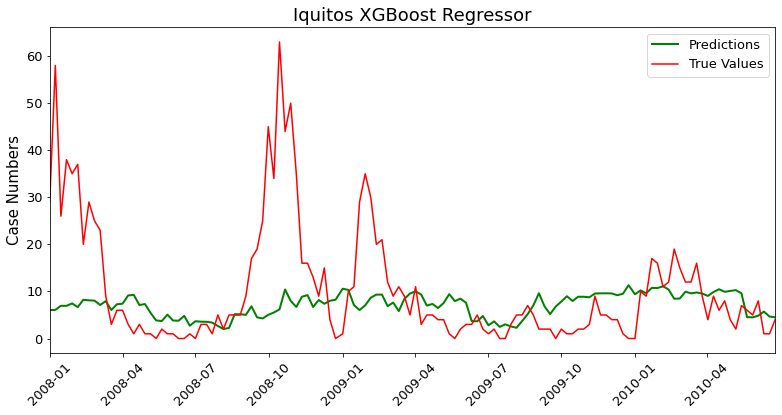

In [51]:
plt.figure(figsize= (13,6))
plt.plot(iq_Ytest.index, iq_x_pred, color= 'g', lw= 2, label= "Predictions")
plt.plot(iq_Ytest, color= 'r', label= "True Values")
plt.title("Iquitos XGBoost Regressor", size= 18)
plt.ylabel("Case Numbers", size= 15)
plt.yticks(size= 13)
plt.xticks(rotation= 45, size= 13)
plt.xlim(iq_Ytest.index[0], iq_Ytest.index[-1])
plt.legend(fontsize= 13)
display(getscores(iq_Ytest, iq_x_pred))

#### Using RFE feature selection

In [28]:
# iq_xgr = XGBRegressor( random_state= 1)
# rsx = RandomizedSearchCV(iq_xgr, xgbR_grid, cv= tscv, 
#                          n_jobs= -1, n_iter= 50, random_state= 1, scoring= rmsle_scorer)  
# rsx.fit(iq_XtrainRolled[iq_RFEfeats], iq_Ytrain)
# rsx.best_params_

In [ ]:
iq_xg_grid = {'colsample_bytree': 0.9946533822621874,
 'gamma': 5.316681065960522,
 'learning_rate': 0.02301947207891894,
 'max_depth': 19,
 'min_child_weight': 182.1037590780387,
 'n_estimators': 240,
 'reg_alpha': 11.067875388692595,
 'subsample': 0.9510831261414849}

iq_xgr = XGBRegressor(random_state= 1, **iq_xg_grid)
iq_xgr.fit(iq_XtrainRolled[iq_RFEfeats], iq_Ytrain) 
iq_x_pred = iq_xgr.predict(iq_XtestRolled[iq_RFEfeats])

{'MAE': 8.022862736995403,
 'SMAPE': 0.4306916621647801,
 'RMSE': 13.054529048404264}

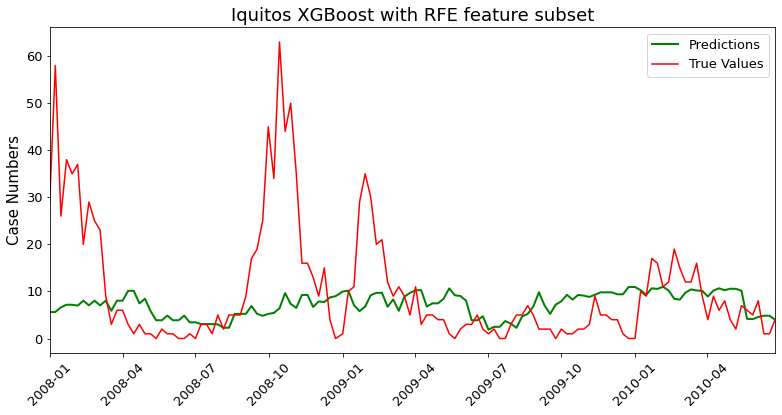

In [53]:
plt.figure(figsize= (13,6))
plt.plot(iq_Ytest.index, iq_x_pred, color= 'g', lw= 2, label= "Predictions")
plt.plot(iq_Ytest, color= 'r', label= "True Values")
plt.title("Iquitos XGBoost with RFE feature subset", size= 18)
plt.ylabel("Case Numbers", size= 15)
plt.yticks(size= 13)
plt.xticks(rotation= 45, size= 13)
plt.xlim(iq_Ytest.index[0], iq_Ytest.index[-1])
plt.legend(fontsize= 13)
display(getscores(iq_Ytest, iq_x_pred))

### San Juan

In [ ]:
# sj_xgr = XGBRegressor(random_state= 1)
# rsx = RandomizedSearchCV(sj_xgr, xgbR_grid, cv= tscv, 
#                          n_jobs= -1, n_iter= 50, random_state= 1, scoring= rmsle_scorer)  
# rsx.fit(sj_XtrainRolled, sj_Ytrain, sample_weight= sj_ytrain_sqrt_weight)
# rsx.best_params_

In [ ]:
sj_xg_grid = {'colsample_bytree': 0.8315424531606493,
 'gamma': 2.035103210479494,
 'learning_rate': 0.010800271065209957,
 'max_depth': 24,
 'min_child_weight': 33.275692814640365,
 'n_estimators': 47,
 'reg_alpha': 39.87517908198642,
 'subsample': 0.8320070378722152}

sj_xgr = XGBRegressor(random_state= 1, **sj_xg_grid)
sj_xgr.fit(sj_XtrainRolled, sj_Ytrain, sample_weight=  sj_ytrain_sqrt_weight)
sj_x_pred = sj_xgr.predict(sj_XtestRolled)

{'MAE': 14.43114008455195,
 'SMAPE': 0.3082143492830078,
 'RMSE': 26.779381826286016}

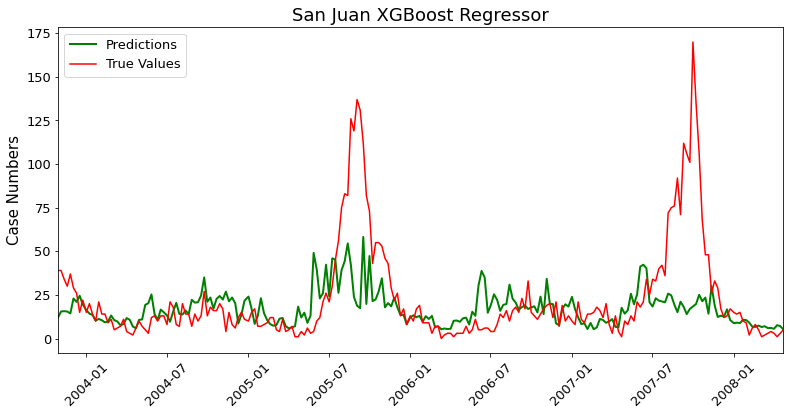

In [57]:
plt.figure(figsize= (13,6))
plt.plot(sj_Ytest.index, sj_x_pred, color= 'g', lw= 2, label= "Predictions")
plt.plot(sj_Ytest, color= 'r', label= "True Values")
plt.title("San Juan XGBoost Regressor", size= 18)
plt.ylabel("Case Numbers", size= 15)
plt.yticks(size= 13)
plt.xticks(rotation= 45, size= 13)
plt.xlim(sj_Ytest.index[0], sj_Ytest.index[-1])
plt.legend(fontsize= 13)
display(getscores(sj_Ytest, sj_x_pred))

The San Juan model isn't overpredicting now. It seems to be doing a better job at the weeks with lower case numbers but is now underpredicting for the weeks of outbreaks.

#### Using RFE feature selection

In [72]:
# sj_xgr = XGBRegressor(random_state= 1)
# rsx = RandomizedSearchCV(sj_xgr, xgbR_grid, cv= tscv, 
#                          n_jobs= -1, n_iter= 50, random_state= 1, scoring= rmsle_scorer)  
# rsx.fit(sj_XtrainRolled[sj_RFEfeats], sj_Ytrain, sample_weight= sj_ytrain_sqrt)
# rsx.best_params_

{'colsample_bytree': 0.914468120024053,
 'gamma': 1.934605692727246,
 'learning_rate': 0.01684310604015972,
 'max_depth': 36,
 'min_child_weight': 23.534980222443657,
 'n_estimators': 42,
 'reg_alpha': 46.377697099165474,
 'subsample': 0.9328069666508334}

In [58]:
#  with RFE features, rmsle_scorer, with sample weights
sj_xg_RFEgrid = {'colsample_bytree': 0.914468120024053,
 'gamma': 1.934605692727246,
 'learning_rate': 0.01684310604015972,
 'max_depth': 36,
 'min_child_weight': 23.534980222443657,
 'n_estimators': 42,
 'reg_alpha': 46.377697099165474,
 'subsample': 0.9328069666508334}

sj_xgrRFE = XGBRegressor(random_state= 1, **sj_xg_RFEgrid)
sj_xgrRFE.fit(sj_XtrainRolled[sj_RFEfeats], sj_Ytrain, sample_weight=  sj_ytrain_sqrt)
sj_xRFE_pred = sj_xgrRFE.predict(sj_XtestRolled[sj_RFEfeats])

{'MAE': 15.04467841091319,
 'SMAPE': 0.32920866270636434,
 'RMSE': 26.71964399758178}

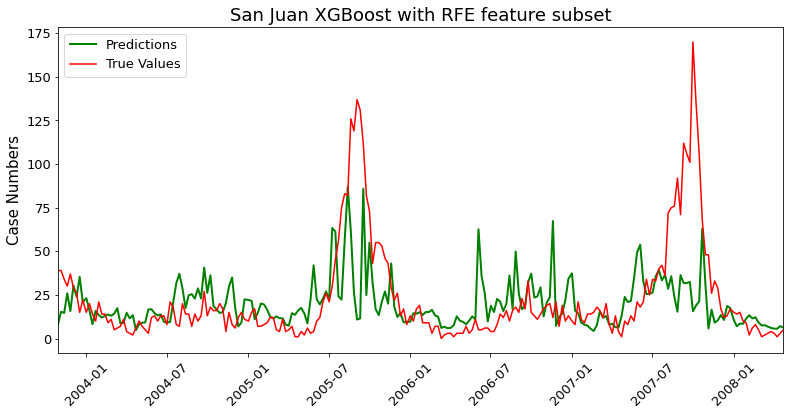

In [59]:
plt.figure(figsize= (13,6))
plt.plot(sj_Ytest.index, sj_xRFE_pred, color= 'g', lw= 2, label= "Predictions")
plt.plot(sj_Ytest, color= 'r', label= "True Values")
plt.title("San Juan XGBoost with RFE feature subset", size= 18)
plt.ylabel("Case Numbers", size= 15)
plt.yticks(size= 13)
plt.xticks(rotation= 45, size= 13)
plt.xlim(sj_Ytest.index[0], sj_Ytest.index[-1])
plt.legend(fontsize= 13)
display(getscores(sj_Ytest, sj_xRFE_pred))